In [1]:
#!pip install pmdarima

In [2]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [3]:
#USDMYR
main_df = pd.read_csv('USDMYR.csv', parse_dates=True, dayfirst=True,  index_col=0,usecols=['Date','Open','High','Low','Close'])
main_df

,Open,High,Low,Close
Date,,,,
2003-12-01,3.7870,3.8031,3.7857,3.7968
2003-12-02,3.7964,3.8021,3.7890,3.7971
2003-12-03,3.7974,3.8037,3.7892,3.7902
2003-12-04,3.7908,3.8075,3.7830,3.7987
2003-12-05,3.7959,3.8029,3.7884,3.7896
...,...,...,...,...
2022-04-20,4.2530,4.2900,4.2520,4.2530
2022-04-21,4.2790,4.2930,4.2790,4.2790
2022-04-22,4.2885,4.3235,4.2885,4.2885


In [4]:
#check missing values
print(main_df.isnull().sum())

Open     9
High     9
Low      9
Close    9
dtype: int64


In [5]:
# Convert all object columns to numerical
main_df = main_df.astype(float)

#Replace missing values in gold data
main_df = main_df.interpolate(limit_direction="both")
print(main_df)

              Open    High     Low   Close
Date                                      
2003-12-01  3.7870  3.8031  3.7857  3.7968
2003-12-02  3.7964  3.8021  3.7890  3.7971
2003-12-03  3.7974  3.8037  3.7892  3.7902
2003-12-04  3.7908  3.8075  3.7830  3.7987
2003-12-05  3.7959  3.8029  3.7884  3.7896
...            ...     ...     ...     ...
2022-04-20  4.2530  4.2900  4.2520  4.2530
2022-04-21  4.2790  4.2930  4.2790  4.2790
2022-04-22  4.2885  4.3235  4.2885  4.2885
2022-04-25  4.3225  4.3540  4.3225  4.3225
2022-04-26  4.3550  4.3550  4.3430  4.3500

[4802 rows x 4 columns]


In [6]:
# Crude Oil Data
oil_data = pd.read_csv('Crude Oil.csv', parse_dates=True, dayfirst=True,  index_col=0,usecols=['Date','Open_Oil','High_Oil','Low_Oil','Close_Oil'])
print(oil_data)
print(oil_data['Open_Oil'].str.contains('-').value_counts()[True])

           Open_Oil High_Oil Low_Oil Close_Oil
Date                                          
2022-04-27   102.11   102.13   100.8    101.03
2022-04-27   101.76   102.99    99.8    102.02
2022-04-26    98.64   102.78   97.06     101.7
2022-04-25   101.38   101.55   95.28     98.54
2022-04-22   104.07   104.22  101.06    102.07
...             ...      ...     ...       ...
2013-08-29   109.53   110.07  107.72     108.8
2013-08-28   109.22   112.24  109.11     110.1
2013-08-27   106.14   109.32  105.88    109.01
2013-08-26   106.91   107.37  105.56    105.92
2013-08-23   105.22   106.94   104.3    106.42

[2187 rows x 4 columns]
3


In [7]:
# Replace string with NaN
oil_data = oil_data.replace(r'-', np.NaN, regex=True)
print(oil_data.isnull().sum())

Open_Oil     3
High_Oil     2
Low_Oil      4
Close_Oil    3
dtype: int64


In [8]:
# Convert all object columns to numerical
oil_data = oil_data.astype(float)

#Replace missing values in gold data
oil_imputed = oil_data.interpolate(limit_direction="both")
print(oil_imputed)

            Open_Oil  High_Oil  Low_Oil  Close_Oil
Date                                              
2022-04-27    102.11    102.13   100.80     101.03
2022-04-27    101.76    102.99    99.80     102.02
2022-04-26     98.64    102.78    97.06     101.70
2022-04-25    101.38    101.55    95.28      98.54
2022-04-22    104.07    104.22   101.06     102.07
...              ...       ...      ...        ...
2013-08-29    109.53    110.07   107.72     108.80
2013-08-28    109.22    112.24   109.11     110.10
2013-08-27    106.14    109.32   105.88     109.01
2013-08-26    106.91    107.37   105.56     105.92
2013-08-23    105.22    106.94   104.30     106.42

[2187 rows x 4 columns]


In [9]:
#Gold Data
gold_data = pd.read_csv('Gold_Price.csv', parse_dates=True, dayfirst=True, index_col=0, usecols=['Date','Open_Gold','High_Gold','Low_Gold','Close_Gold'])
print(gold_data)
print(gold_data['Open_Gold'].str.contains('-').value_counts()[True])

           Open_Gold High_Gold Low_Gold Close_Gold
Date                                              
2022-04-27    1886.8    1887.3   1880.4     1883.4
2022-04-27    1897.8    1900.6   1882.2     1885.9
2022-04-26    1900.5    1909.1     1894     1901.4
2022-04-25      1925      1925   1889.3     1893.2
2022-04-22    1949.6    1950.4   1930.2       1931
...              ...       ...      ...        ...
2000-09-05     275.8     275.8    275.8      275.8
2000-09-04         -         -        -          -
2000-09-01       277       277      277        277
2000-08-31     274.8     278.3    274.8      278.3
2000-08-30     273.9     273.9    273.9      273.9

[5516 rows x 4 columns]
81


In [10]:
# Replace string with NaN
gold_data = gold_data.replace(r'-', np.NaN, regex=True)
print(gold_data.isnull().sum())

Open_Gold     81
High_Gold     81
Low_Gold      81
Close_Gold    81
dtype: int64


In [11]:
# Convert all object columns to numerical
gold_data = gold_data.astype(float)
gold_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5516 entries, 2022-04-27 to 2000-08-30
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open_Gold   5435 non-null   float64
 1   High_Gold   5435 non-null   float64
 2   Low_Gold    5435 non-null   float64
 3   Close_Gold  5435 non-null   float64
dtypes: float64(4)
memory usage: 215.5 KB


In [12]:
#Replace missing values in gold data
gold_imputed = gold_data.interpolate(limit_direction="both")
print(gold_imputed)

            Open_Gold  High_Gold  Low_Gold  Close_Gold
Date                                                  
2022-04-27     1886.8     1887.3    1880.4      1883.4
2022-04-27     1897.8     1900.6    1882.2      1885.9
2022-04-26     1900.5     1909.1    1894.0      1901.4
2022-04-25     1925.0     1925.0    1889.3      1893.2
2022-04-22     1949.6     1950.4    1930.2      1931.0
...               ...        ...       ...         ...
2000-09-05      275.8      275.8     275.8       275.8
2000-09-04      276.4      276.4     276.4       276.4
2000-09-01      277.0      277.0     277.0       277.0
2000-08-31      274.8      278.3     274.8       278.3
2000-08-30      273.9      273.9     273.9       273.9

[5516 rows x 4 columns]


In [13]:
#FBM KLCI data
fbmklci = pd.read_csv('FBMKLCI.csv', parse_dates=True, dayfirst=True, index_col=0)

fbmklci

,Open_FBMKLCI,High_FBMKLCI,Low_FBMKLCI,Close_FBMKLCI
Date,,,,
2022-05-23,1542.53,1542.53,1542.53,1542.53
2022-05-20,1549.12,1549.12,1549.12,1549.12
2022-05-19,1549.41,1549.41,1549.41,1549.41
2022-05-18,1554.91,1554.91,1554.91,1554.91
2022-05-17,1548.60,1548.60,1548.60,1548.60
...,...,...,...,...
2013-08-01,1688.91,1688.91,1688.91,1688.91
2013-07-01,1694.16,1694.16,1694.16,1694.16
2013-04-01,1692.58,1692.58,1692.58,1692.58


In [14]:
USDMYR_Oil = pd.merge(main_df, oil_imputed, how='inner', on='Date')
USDMYR_Oil 

,Open,High,Low,Close,Open_Oil,High_Oil,Low_Oil,Close_Oil
Date,,,,,,,,
2013-08-23,3.3079,3.3116,3.1248,3.2984,105.22,106.94,104.30,106.42
2013-08-26,3.2966,3.3081,3.2859,3.3015,106.91,107.37,105.56,105.92
2013-08-27,3.3092,3.3362,3.2911,3.3277,106.14,109.32,105.88,109.01
2013-08-28,3.3278,3.3385,3.3150,3.3315,109.22,112.24,109.11,110.10
2013-08-29,3.3175,3.3249,3.2916,3.3078,109.53,110.07,107.72,108.80
...,...,...,...,...,...,...,...,...
2022-04-20,4.2530,4.2900,4.2520,4.2530,103.05,104.16,100.70,102.75
2022-04-21,4.2790,4.2930,4.2790,4.2790,102.50,105.42,102.01,103.79
2022-04-22,4.2885,4.3235,4.2885,4.2885,104.07,104.22,101.06,102.07


In [15]:
join_fbmklci = pd.merge(USDMYR_Oil, fbmklci, how='inner', on='Date')
join_fbmklci

,Open,High,Low,Close,Open_Oil,High_Oil,Low_Oil,Close_Oil,Open_FBMKLCI,High_FBMKLCI,Low_FBMKLCI,Close_FBMKLCI
Date,,,,,,,,,,,,
2013-08-23,3.3079,3.3116,3.1248,3.2984,105.22,106.94,104.30,106.42,1721.07,1721.07,1721.07,1721.07
2013-08-26,3.2966,3.3081,3.2859,3.3015,106.91,107.37,105.56,105.92,1722.49,1722.49,1722.49,1722.49
2013-08-27,3.3092,3.3362,3.2911,3.3277,106.14,109.32,105.88,109.01,1701.24,1701.24,1701.24,1701.24
2013-08-28,3.3278,3.3385,3.3150,3.3315,109.22,112.24,109.11,110.10,1686.17,1686.17,1686.17,1686.17
2013-08-29,3.3175,3.3249,3.2916,3.3078,109.53,110.07,107.72,108.80,1703.78,1703.78,1703.78,1703.78
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-20,4.2530,4.2900,4.2520,4.2530,103.05,104.16,100.70,102.75,1593.75,1593.75,1593.75,1593.75
2022-04-21,4.2790,4.2930,4.2790,4.2790,102.50,105.42,102.01,103.79,1598.32,1598.32,1598.32,1598.32
2022-04-22,4.2885,4.3235,4.2885,4.2885,104.07,104.22,101.06,102.07,1601.97,1601.97,1601.97,1601.97


In [16]:
data_join = pd.merge(join_fbmklci, gold_imputed, how='inner', on='Date')
data_join

,Open,High,Low,Close,Open_Oil,High_Oil,Low_Oil,Close_Oil,Open_FBMKLCI,High_FBMKLCI,Low_FBMKLCI,Close_FBMKLCI,Open_Gold,High_Gold,Low_Gold,Close_Gold
Date,,,,,,,,,,,,,,,,
2013-08-23,3.3079,3.3116,3.1248,3.2984,105.22,106.94,104.30,106.42,1721.07,1721.07,1721.07,1721.07,1376.8,1398.2,1373.9,1395.7
2013-08-26,3.2966,3.3081,3.2859,3.3015,106.91,107.37,105.56,105.92,1722.49,1722.49,1722.49,1722.49,1398.6,1402.8,1391.3,1393.0
2013-08-27,3.3092,3.3362,3.2911,3.3277,106.14,109.32,105.88,109.01,1701.24,1701.24,1701.24,1701.24,1403.8,1421.1,1398.7,1420.6
2013-08-28,3.3278,3.3385,3.3150,3.3315,109.22,112.24,109.11,110.10,1686.17,1686.17,1686.17,1686.17,1417.3,1428.0,1417.3,1419.0
2013-08-29,3.3175,3.3249,3.2916,3.3078,109.53,110.07,107.72,108.80,1703.78,1703.78,1703.78,1703.78,1417.4,1417.4,1404.5,1412.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-20,4.2530,4.2900,4.2520,4.2530,103.05,104.16,100.70,102.75,1593.75,1593.75,1593.75,1593.75,1945.5,1953.6,1945.5,1952.3
2022-04-21,4.2790,4.2930,4.2790,4.2790,102.50,105.42,102.01,103.79,1598.32,1598.32,1598.32,1598.32,1942.5,1944.9,1942.5,1944.9
2022-04-22,4.2885,4.3235,4.2885,4.2885,104.07,104.22,101.06,102.07,1601.97,1601.97,1601.97,1601.97,1949.6,1950.4,1930.2,1931.0


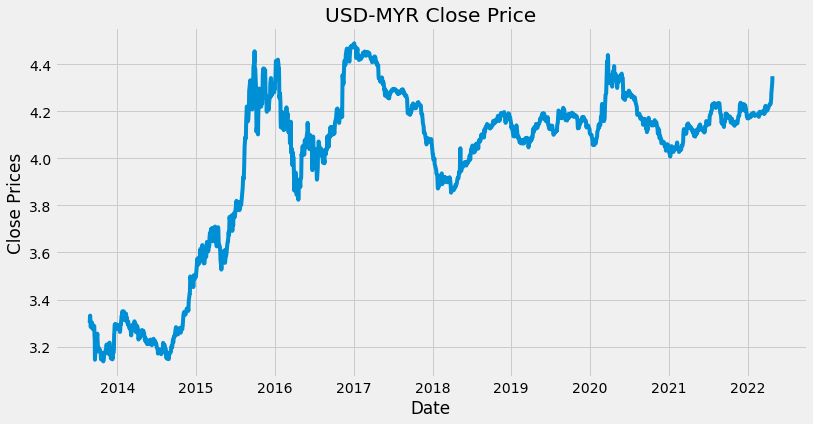

In [17]:
# plot close price
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(data_join['Close'])
plt.title('USD-MYR Close Price')
plt.show()

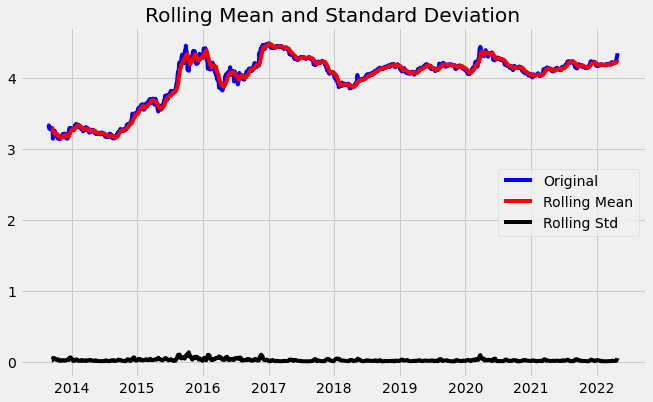

Results of Dickey Fuller Test
Test Statistics                  -2.167204
p-value                           0.218363
No. of lags used                 16.000000
Number of observations used    1880.000000
critical value (1%)              -3.433833
critical value (5%)              -2.863079
critical value (10%)             -2.567589
dtype: float64


In [18]:
# test for stationarity
def test_stationarity(timeseries):
    # determining rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # plot rolling statistics:
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of Dickey Fuller Test")
    adft = adfuller(timeseries, autolag='AIC')
    
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

df_close = data_join['Close']    
test_stationarity(df_close)

<Figure size 720x432 with 0 Axes>

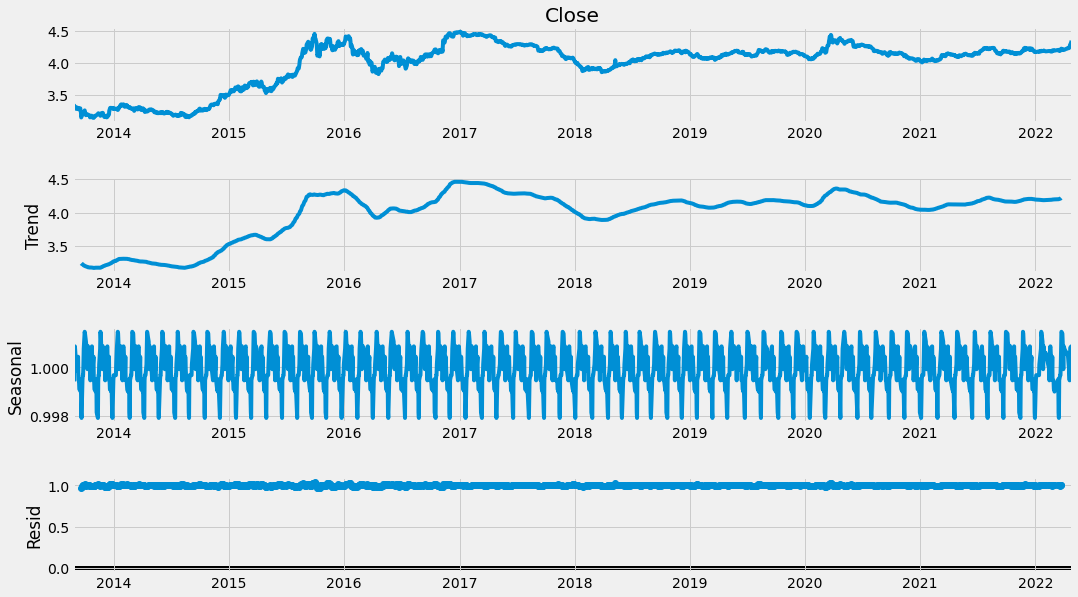

In [19]:
# trend and seasonality 
result = seasonal_decompose(df_close, model='multiplicative', period =30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

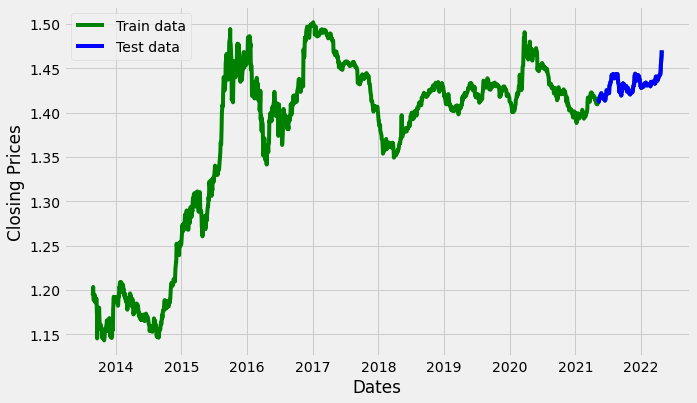

In [20]:
df_log = np.log(df_close)

#split data into train and test set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13150.339, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-13148.472, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-13148.470, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-13151.315, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-13146.068, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.308 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1704
Model:               SARIMAX(0, 1, 0)   Log Likelihood                6576.657
Date:                Fri, 03 Jun 2022   AIC                         -13151.315
Time:                        10:40:40   BIC                         -13145.875
Sample:                             0   HQIC                        -13149.301
                               - 1704                             

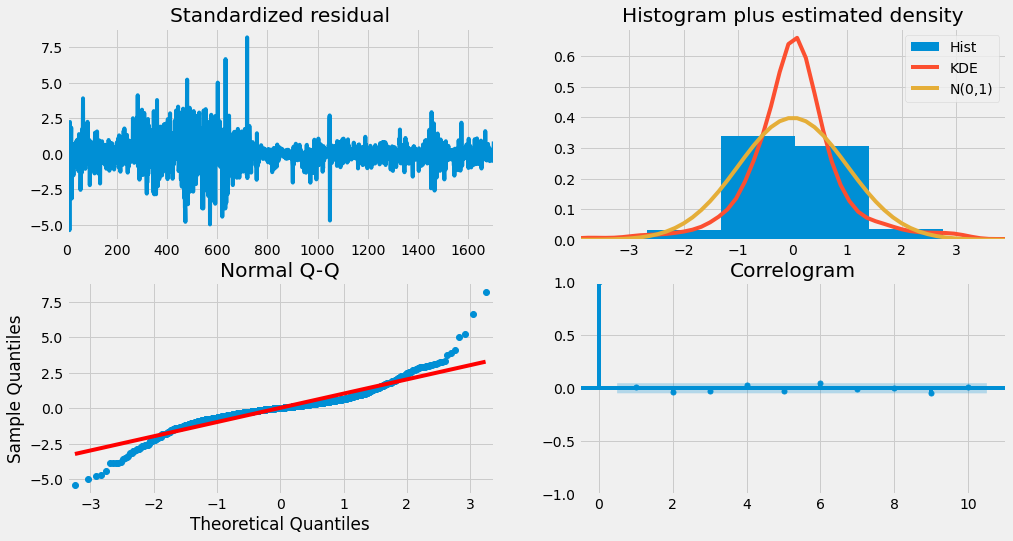

In [21]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [22]:
# build ARIMA model
model = ARIMA(train_data, order=(0,1,0))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1704
Model:                 ARIMA(0, 1, 0)   Log Likelihood                6576.657
Date:                Fri, 03 Jun 2022   AIC                         -13151.315
Time:                        10:40:40   BIC                         -13145.875
Sample:                             0   HQIC                        -13149.301
                               - 1704                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.588e-05   4.02e-07     64.318      0.000    2.51e-05    2.67e-05
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):              4217.97
Prob(Q):                              0.71   Pr

c:\Users\iqmalhafiyy\Anaconda3\envs\forex\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\iqmalhafiyy\Anaconda3\envs\forex\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\iqmalhafiyy\Anaconda3\envs\forex\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [23]:
# forecast on test data
# fc, se, conf = fitted.forecast(3, False, alpha=0.001)
# print(conf)
# print(fc)
# print(se)
# print(fitted)

TypeError: forecast() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
# # Make as pandas series
# fc_series = pd.Series(fc, index=test_data.index)
# lower_series = pd.Series(conf, index=test_data.index)
# upper_series = pd.Series(conf, index=test_data.index)
# # Plot
# plt.figure(figsize=(10,5), dpi=100)
# plt.plot(train_data, label='training data')
# plt.plot(test_data, color = 'blue', label='Actual Stock Price')
# plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
# plt.title('USD-MYR Price Prediction')
# plt.xlabel('Time')
# plt.ylabel('USD_MYR Price')
# plt.legend(loc='upper left', fontsize=8)
# plt.show()